## Mouse pancreatic endocrinogenesis (scATAC-seq) | Model evaluation

### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [1]:
print('here...')

here...


In [2]:
%load_ext autoreload
%autoreload 2

If you wish to test this notebook but have not trained models, you can download example output from this cloud link. 
[**Dropbox URL**](https://www.dropbox.com/scl/fo/7h98je53on9vl1u8o0gqm/APUZFwi1dWZM2ELoZqS3XbM?rlkey=cty8wpyyx8zjmh4v5yj3tshet&dl=0)

Four files are required
- Model output (*.pth) using GraphLayer (log_dynamic=1) and not using it (log_dynamic=0)
- ATAC (atac_train) and RNA (rna_sample_train).
- Training dataloader (train_dataloader).

If a file for testing is n/a, or there are clarifications while loading, please reach out via [Github](https://github.com/theislab/mubind/issues/131).

In [7]:
# pip install matplotlib==3.7.2

In [8]:
import torch
import mubind as mb
import scanpy as sc

In [9]:
# the prepring case (4148)
# Graph Layer with hadamard product 8161 x 50000
n_obs = 8161
n_var = 50000
save_code = '_obs%i_var%i' % (n_obs, n_var)

In [10]:
# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = "pancreas_multiome_use_logdynamic_%i_obs8161_var50000.pth" % use_logdynamic
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

pancreas_multiome_use_logdynamic_0_obs8161_var50000.pth
pancreas_multiome_use_logdynamic_1_obs8161_var50000.pth


In [11]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/atac_train*

-rwxrwxrwx 1 ilibarra ilibarra 289K Aug 27 00:03 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/atac_train.h5ad
-rwxrwxrwx 1 ilibarra ilibarra 209M Aug 30 12:10 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/atac_train_obs8161_var50000.h5ad


In [12]:
# this loads the atac and RNA objects subsampled and used during training
ad = sc.read_h5ad('atac_train%s.h5ad' % save_code)
rna_sample = sc.read_h5ad('rna_sample_train_obs%i.h5ad' % (n_obs))

In [13]:
import pickle


train = pickle.load(open('train_dataloader%s.pkl' % save_code, "rb"))

In [14]:
%load_ext line_profiler

In [15]:
!readlink -f .

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/single_cell


In [16]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome(data_directory="../../../../../../annotations/single_cell")

True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad
reading ATAC
opening ATAC successful


In [17]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [18]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [19]:
import matplotlib.pyplot as plt

In [20]:
cell_type_key = "celltype"

Graph Layer |  False
break


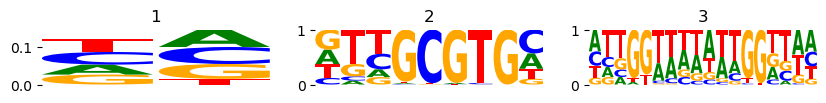

Graph Layer |  True
break


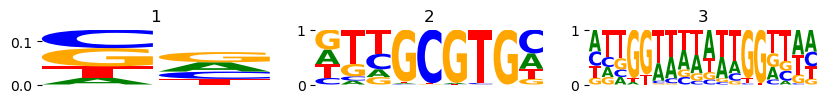

In [21]:
for optimize_log_dynamic in model_by_logdynamic:
    print("Graph Layer | ", optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # print(optimize_log_dynamic)
    from matplotlib import rcParams

    rcParams["figure.figsize"] = 10, 5
    rcParams["figure.dpi"] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4)  #  log=True)
    plt.show()

True


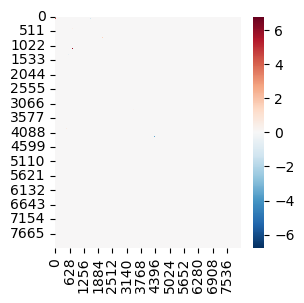

In [22]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)

    import seaborn as sns

    mb.pl.set_rcParams({"figure.figsize": [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap="RdBu_r")
    plt.show()

In [23]:
model = model_by_logdynamic[1]

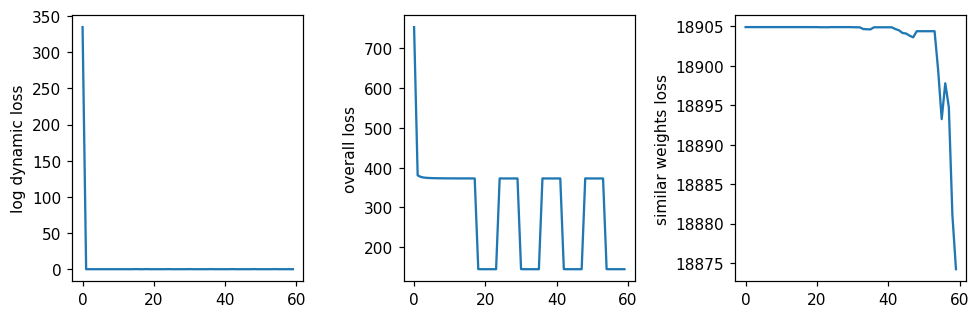

In [24]:
mb.pl.set_rcParams({"figure.figsize": [12, 3], "figure.dpi": 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel("log dynamic loss")
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel("overall loss")
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel("similar weights loss")
plt.tight_layout()

plt.savefig('losses_pancreatic_endocrinogenesis.pdf')
plt.show()

In [25]:
import pandas as pd
import numpy as np

False
True


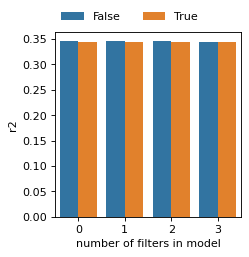

In [26]:
rcParams["figure.figsize"] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns

    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=["r2"]).reset_index()
        r2["opt_log_dynamic"] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams["figure.figsize"] = 3, 3
    rcParams["figure.dpi"] = 80
    ax = sns.barplot(
        data=r2_all,
        x="index",
        y="r2",
        hue="opt_log_dynamic",
    )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel("number of filters in model")
    plt.show()

In [27]:
model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs["dynamic_score"] = dynamic_score

ad.obs["dynamic_score_cluster"] = np.where(dynamic_score > dynamic_score.mean(), "dynamic", "static")
z0 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 0.75, "dynamic", "static")
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, "dynamic", "static")
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, "dynamic", "static")

ad.obs["dynamic_score_z0"] = z0
ad.obs["dynamic_score_z1"] = z1
ad.obs["dynamic_score_z2"] = z2

In [28]:
ad.obs[[c for c in ad.obs if 'dynamic' in c]].describe()

dynamic_score
count    8161.000000
mean        0.308962
std         0.040538
min         0.000000
25%         0.308942
50%         0.308962
75%         0.308974
max         1.000000

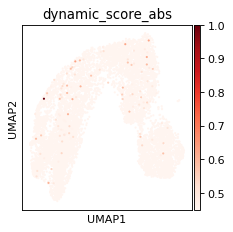

In [29]:
ad.obs["dynamic_score_abs"] = ad.obs["dynamic_score"].abs()
sc.pl.umap(ad, color="dynamic_score_abs", color_map="Reds", vmin=0.45)

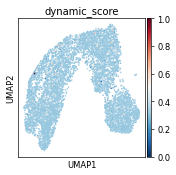

z0


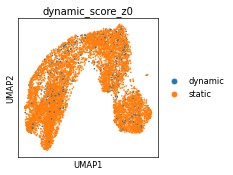

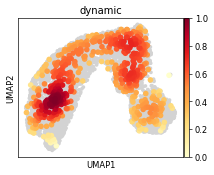

z1


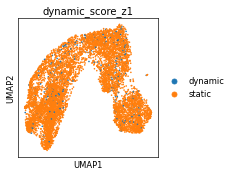

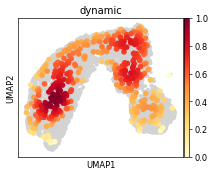

z2


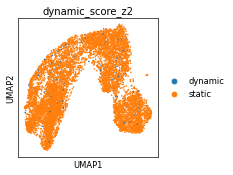

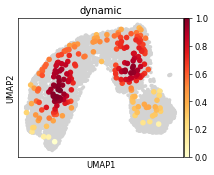

In [30]:
# contributions per newly added kernel
mb.pl.set_rcParams({"figure.figsize": [3, 3], "figure.dpi": 60})

sc.pl.umap(ad, color=["dynamic_score"], cmap="RdBu_r", sort_order=True)

for z in ['z0', 'z1', 'z2']:
    print(z)
    sc.pl.umap(ad, color=["dynamic_score_%s" % z], cmap="RdBu_r", sort_order=True)
    sc.tl.embedding_density(ad, basis="umap", groupby="dynamic_score_%s" % z)
    sc.pl.embedding_density(
        ad, basis="umap", key="umap_density_dynamic_score_%s" % z, group="dynamic"
    )  # basis='umap', groupby='dynamic_score_cluster')


<Axes: >

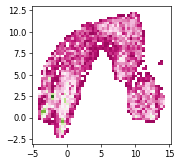

In [31]:
import seaborn as sns

umap = ad.obsm["X_umap"]
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap="PiYG")

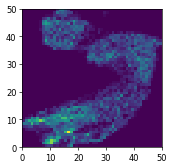

In [32]:
plt.pcolormesh(np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0])

In [33]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [34]:
x = umap[:, 1]  # array_txt[:,0]
y = umap[:, 1]  # array_txt[:,1]
z = ad.obs["dynamic_score"].values  # array_txt[:,2]

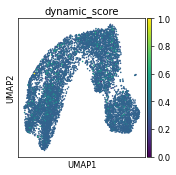

In [35]:
sc.pl.umap(ad, color="dynamic_score")

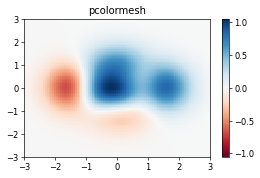

In [36]:
import matplotlib.pyplot as plt
import numpy as np

rcParams["figure.figsize"] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2.0 + x**5 + y**3) * np.exp(-(x**2) - y**2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap="RdBu", vmin=z_min, vmax=z_max)
ax.set_title("pcolormesh")
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [37]:
import itertools
import numpy as np


def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)

In [38]:
grid_dyn_score = grid(umap[:, 0], umap[:, 1], ad.obs["dynamic_score"], size_x=1, size_y=1)
grid_counts = grid(umap[:, 0], umap[:, 1], ad.obs["celltype"].cat.codes.values, size_x=1, size_y=1)

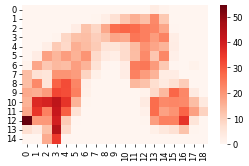

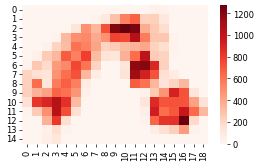

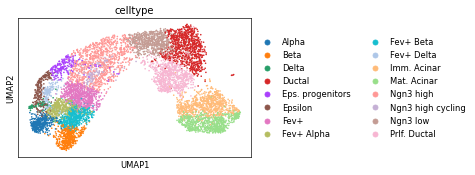

In [39]:
sns.heatmap(grid_dyn_score, cmap="Reds")
plt.show()
sns.heatmap(grid_counts, cmap="Reds")
plt.show()

sc.pl.umap(ad, color="celltype")

In [40]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()

In [41]:
model = model_by_logdynamic[True]

In [42]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense()  # (C, C)

In [43]:
# number of non_zero weights
len(G[G != 0])

111684

In [44]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [46]:
ad

AnnData object with n_obs × n_vars = 8161 × 50000
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z0', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z0', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'modality', 'acc_score', 'acc_score_rank', 'chr', 'start', 'end', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'celltype_colors', 'neighbors', 'dynamic_score_z0_colors', 'umap_density_dynamic_score_z0_params', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'dynamic_score_z2_colors', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_pca_wsnn',

In [47]:
model = model.cuda()

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [49]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm["X_umap"].copy()
    umap = np.sort(umap, 0)

    x = umap[:, 0]
    y = umap[:, 1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    binding_per_mode = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum, "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs["scale_countsum"] = model.datatype == "selex"
        output = model(**inputs, use_conn=False, return_binding_scores=True)
        output = output.cpu().detach().numpy()
        # print("here...")
        # print(output.shape)
        # print(output.sum())
        pred.append(output)


        output = model(**inputs, use_conn=False, return_binding_per_mode=True)
        output = output.cpu().detach().numpy()
        # print("here...")
        # print(output.shape)
        # print(output.sum())
        binding_per_mode.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T
    binding_per_mode = np.concatenate(binding_per_mode)

    # ad.layers['velocity'] = pred

    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()

    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']

    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True


In [50]:
ad.shape, binding_per_mode.shape

((8161, 50000), (50000, 288))

In [51]:
import scvelo as scv

In [52]:
ad.shape, binding_per_mode.shape

((8161, 50000), (50000, 288))

In [53]:
ad
ad.layers["velocity"] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [54]:
np.random.shuffle(binding_scores)
binding_scores

array([[2326852.2 , 2244617.5 , 2257599.  , ..., 1032774.  , 1101569.4 ,
         961977.94],
       [2324817.8 , 2242753.2 , 2255925.8 , ..., 1032444.9 , 1101183.8 ,
         961662.06],
       [2325369.8 , 2243328.2 , 2256494.2 , ..., 1032580.2 , 1101346.9 ,
         961793.75],
       ...,
       [2327202.2 , 2244936.2 , 2257899.  , ..., 1032709.25, 1101466.1 ,
         961898.75],
       [2325772.2 , 2243165.2 , 2255936.8 , ..., 1032531.44, 1101306.5 ,
         961750.56],
       [2325220.8 , 2243139.8 , 2256282.5 , ..., 1032513.7 , 1101264.5 ,
         961729.3 ]], dtype=float32)

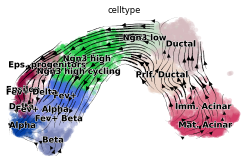

In [55]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color="celltype")
except Exception:
    print("sample too small.")

In [56]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

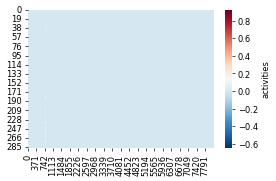

In [57]:
import seaborn as sns


act = model.get_log_activities().detach().cpu().squeeze(0)

sns.heatmap(act, cmap="RdBu_r", cbar_kws={"label": "activities"})

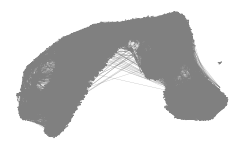

In [58]:
scv.pl.velocity_graph(rna)

In [59]:
# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [60]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [61]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

### Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [62]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 8161 × 14663
     obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch', 'velocity_self_transition'
     var: 'modality', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
     uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
     obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX', 'velocity_umap'
     layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced',

In [63]:
rna_sel = rna_sample  # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(8161, 14663)

In [64]:
pwd

'/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/single_cell'

In [67]:
import bindome as bd


bd.constants.ANNOTATIONS_DIRECTORY = "annotations"
anno = mb.datasets.archetypes_anno()

In [69]:
rna_sel.shape
anno.sort_values("Cluster_ID")

Cluster_ID          Name          DBD             Seed_motif  \
61            1          HD/1  homeodomain     LHX6_homeodomain_3   
72            2          HD/2  homeodomain          ALX3_MA0634.1   
79            3          HD/3  homeodomain    VENTX_homeodomain_2   
80            4          HD/4  homeodomain  BARX1_MOUSE.H11MO.0.C   
81            5          HD/5  homeodomain    BARX1_homeodomain_1   
..          ...           ...          ...                    ...   
163         282         PAX/2          PAX   PAX5_HUMAN.H11MO.0.A   
161         283  PAX-halfsite          PAX          Pax2_MA0067.1   
0           284           AHR         bHLH    AHR_HUMAN.H11MO.0.B   
105         285      KLF/SP/3         C2H2   KLF8_HUMAN.H11MO.0.C   
285         286        ZSCAN4         C2H2          ZSCAN4_C2H2_1   

     Total_width  Consensus_left  Consensus_right  Cluster_size  
61            12               0               12             2  
72            26               8               16           186  
79            21               3               20             1  
80            17               5               13            17  
81            21               2               18             6  
..           ...             ...              ...           ...  
163           24               4               21             3  
161            8               1                7             1  
0              9               2                8             3  
105            9               0                9             2  
285           15               1               14             2  

[286 rows x 8 columns]

False


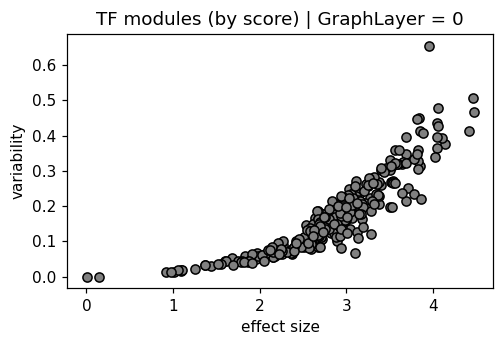

True


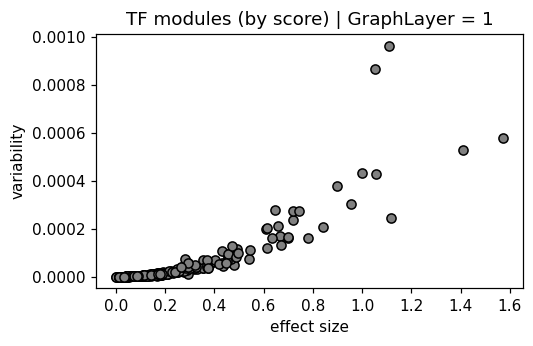

In [70]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm["mubind_activities"] = log_act

    mb.pl.set_rcParams({"figure.figsize": [5, 3], "figure.dpi": 110})
    delta = log_act.max(axis=0) - log_act.min(axis=0)
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color="gray", edgecolors="black")
    plt.xlabel("effect size")
    plt.ylabel("variability")
    plt.title("TF modules (by score) | GraphLayer = %i" % optimize_log_dynamic)
    plt.show()

In [71]:
# unique names for annotation
names = anno["Name"]  # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + "_%i" % added[name])
        added[name] += 1
anno["Name_unique"] = new_name

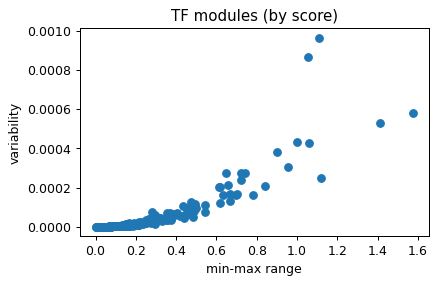

In [72]:
from scipy.stats import spearmanr


res = []

for optimize_log_dynamic in model_by_logdynamic:

    if not optimize_log_dynamic:
        continue


    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)

    log_act = pd.DataFrame(log_act.detach().cpu().numpy())

    # log_act.columns = anno['Seed_motif'][2]

    log_act.columns = ["intercept", "dinuc_bias"] + list(range(1, 287))

    log_act.index = ad.obs_names

    ad.obsm["mubind_activities"] = log_act


    mb.pl.set_rcParams({"figure.figsize": [5, 3], "figure.dpi": 90})

    delta = log_act.max(axis=0) - log_act.min(axis=0)

    var = log_act.var(axis=0)

    plt.scatter(delta, var)

    plt.xlabel("min-max range")

    plt.ylabel("variability")

    plt.title("TF modules (by score)")

    plt.show()


    for c in log_act:

        a = log_act[c]

        b = ad.obs["dynamic_score"].values

        # print(a.shape, b.shape)

        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))


res = pd.DataFrame(res, columns=["opt_log_dynamic", "archetype_id", "spearman", "p_val"])

In [73]:
# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ["max_effect", "variability"]
meta["name"] = ["intercept", "dinuc_bias"] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta["archetypes_name"] = meta["name"].map(anno.set_index("Cluster_ID")["Name_unique"])
meta["archetypes_name"] = np.where(pd.isnull(meta["archetypes_name"]), meta["name"], meta["archetypes_name"])

meta["archetypes_seed"] = meta["name"].map(anno.set_index("Cluster_ID")["Seed_motif"])
meta = meta.sort_values("max_effect", ascending=0)
meta

res = res.merge(meta, left_on="archetype_id", right_on="name")
res = res.sort_values("p_val", ascending=True)

In [74]:
name_by_filter_id = meta["archetypes_name"].to_dict()
# name_by_filter_id

### Observe general scores per binding layer filter

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

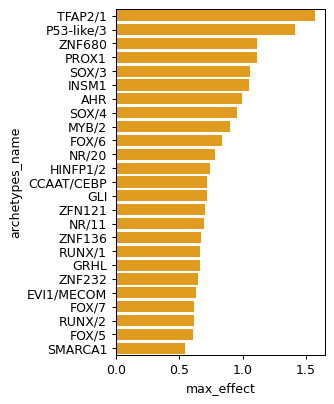

In [75]:
rcParams["figure.figsize"] = 3, 5
sns.barplot(
    data=res.sort_values("max_effect", ascending=False).head(25), x="max_effect", y="archetypes_name", color="orange"
)

In [77]:
pd.options.display.width = 1000

break


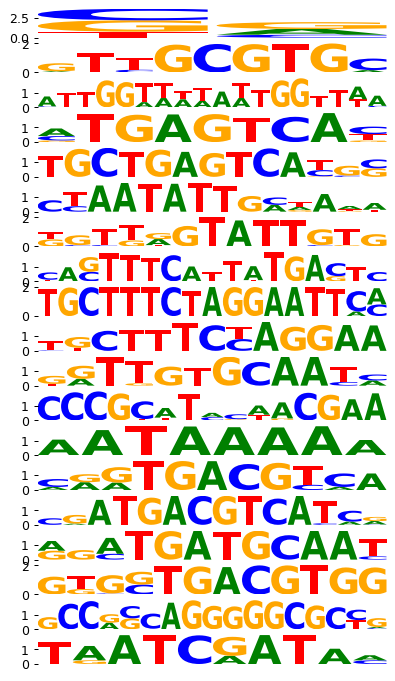

In [78]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({"figure.figsize": [5, 20], "figure.dpi": 90})
# mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=5, log_odds=False)
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20, log_odds=True)
# n_rows=len(res.head(20).index),

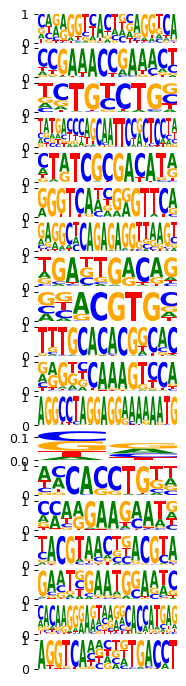

<Figure size 180x1800 with 0 Axes>

In [79]:
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=res.head(20).index,
)  # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [80]:
import resource

print("total GB used:", resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)

total GB used: 24.692796


In [81]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')

In [82]:
rna_sel.obsm["X_umap"] = ad.obsm["X_umap"]

In [83]:
def find_varname(ad, k, shuffle=False):
    if not shuffle:
        return ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
    else:
        ad_sel = ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
        return pd.Series(ad.var_names).sample(ad_sel.shape[0]).values

In [84]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [85]:
all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm["log_activities"] = log_act
    ad.obsm["log_activities"].columns = ["intercept", "dinuc_bias"] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm["log_activities"].iloc[:, 2:]:
        log_act = ad.obsm["log_activities"][k].values
        names = set()
        clu_sel = clu[clu["Cluster_ID"] == k]["Motif"]
        for g in clu_sel:
            names.add(g.split("_")[0].split(".")[0].split("+")[0].upper())
        for g in anno[anno["Cluster_ID"] == k]["Seed_motif"]:
            names.add(g.split("_")[0].split(".")[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap="Reds")

False
True


In [86]:

def get_act_gene_corr(model_by_logdynamic, shuffle=False, random_state=0):
    print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
    res = []
    # print(len(all_targets))

    rna_sel_df = rna_sel.to_df()

    for optimize_log_dynamic in model_by_logdynamic:
        print('use GraphLayer = %i' % optimize_log_dynamic)
        model = model_by_logdynamic[optimize_log_dynamic]

        log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
        log_act = pd.DataFrame(log_act.detach().cpu().numpy())
        log_act.index = ad.obs_names

        ad.obsm['log_activities'] = log_act
        ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

        # if shuffle:
        #     random_cols = ad.obsm['log_activities'].iloc[:,2:].columns.values
        #     np.random.shuffle(random_cols)
        #     # random_cols
        
        for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
            next_log_act = ad.obsm['log_activities'][k].values

            # if shuffle:
            #     next_log_act = ad.obsm['log_activities'][random_cols[ki]].values
            
            # print(ki)
            # if ki % 30 == 0:
            #     print(ki)
            names = set()
            clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
            for g in clu_sel:
                names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
            for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
                names.add(g.split('_')[0].split('.')[0])
            # print(k, names)
            next_targets = set()
            for name in names:
                target = find_varname(rna_sel, name, shuffle=shuffle)
                # print(name, target)
                for t in target:
                    next_targets.add(t)

            # for t in all_targets:
            for t in set(all_targets).intersection(next_targets):
                gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
                assert gex.shape[1] == 1
                gex = gex.flatten()
                # print(next_log_act.shape, gex.shape)
                # print(t, pearsonr(next_log_act, gex))
                res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                        list(spearmanr(next_log_act, gex)))
                
    res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

    # p-values
    res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
    res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])
    
    # p-val adjust
    from statsmodels.stats.multitest import fdrcorrection
    res['p_adj'] = fdrcorrection(res['p_val'])[1]
    return res


In [87]:
res = get_act_gene_corr(model_by_logdynamic)
print('\nRunning permutations...')
n_perm = 10
shuffled = []
for i in range(n_perm):
    print(i)
    shuffled.append(get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i))
# shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i) for i in range(50)]

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1

Running permutations...
0
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
2
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
3
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
4
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
5
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
6
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
7
association between motif activities and related TF targets (sh

In [88]:
table = []
for use_graph in [False, True]:
    for thr in range(1, 10):
        sel = res[res['opt_log_dynamic'] == use_graph]
        next_thr = 10 ** (-thr)
        n_pos = sel[sel['p_adj'] < next_thr].shape[0]
        n_neg = [s[(s['p_adj'] < next_thr) & (s['opt_log_dynamic'] == use_graph)].shape[0] for s in shuffled]
        # print(next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg))
        table.append([next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg), use_graph])
table = pd.DataFrame(table, columns=['p_adj_thr', 'n_pos', 'mu', 'sigma', 'zscore', 'graph_layer'])
table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore')

p_adj_thr    1.000000e-09  1.000000e-08  1.000000e-07  1.000000e-06  1.000000e-05  1.000000e-04  1.000000e-03  1.000000e-02  1.000000e-01
graph_layer                                                                                                                              
False           25.955710     27.872501     27.910294     35.532982     37.300271     38.454778     51.310414     54.805231     68.835313
True            10.512276     13.535528     13.312500     15.649224     26.665466     35.235294     35.433265     33.995949     63.204079

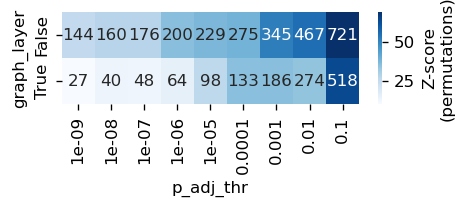

In [89]:
rcParams['figure.figsize'] = 4, 1
rcParams['figure.dpi'] = 120
rcParams['pdf.fonttype'] = 42
hm = table.pivot(index='graph_layer', columns='p_adj_thr', values='n_pos').fillna(0)
z = table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore').fillna(0)
sns.heatmap(z, annot=hm, fmt='', cmap='Blues', # vmin=0, vmax=5,
            cbar_kws={'label': 'Z-score\n(permutations)'})

plt.savefig('../../../output/zscore_filter_act_gex_cor_pancreatic_endocrinogesis.pdf')
plt.show()

In [90]:
genes_by_module_name = (
    res.groupby(["module_name"])["gene_name"].apply(lambda grp: list(grp.value_counts().index)).to_dict()

)
# genes_by_module_name

In [91]:
res.sort_values("p_adj")

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman          p_val module_name          p_adj
277          68            False            69     Meis2     True  0.253829  3.531138e-120        MIES  1.363019e-116
1711        245            False           246      Rfx6     True -0.246340  4.372267e-113       RFX/3  8.438475e-110
1588        150            False           151      Rest     True  0.237454  5.574720e-105   REST/NRSF  7.172807e-102
1377         81            False            82    Pou3f4     True  0.227013   7.048015e-96       POU/2   6.801334e-93
1436         95            False            96       Ehf     True  0.219672   9.477964e-90       ETS/2   7.316988e-87
...         ...              ...           ...       ...      ...       ...            ...         ...            ...
3449        108             True           109      Egr1     True  0.000016   9.988476e-01    KLF/SP/2   9.996254e-01
2723         69             True            70   Thumpd1     True -0.000016   9.988485e-01       TBX/1   9.996254e-01
1152         69            False            70  Tnfrsf22     True  0.000005   9.996116e-01       TBX/1   9.998707e-01
2930         69             True            70   Tpd52l1     True  0.000008   9.993975e-01       TBX/1   9.998707e-01
1406         91            False            92     Sox11     True -0.000002   9.998756e-01       SOX/3   9.998756e-01

[3860 rows x 9 columns]

In [92]:
res["k"] = res["gene_name"] + "_" + res["archetype_id"].astype(str)
df2 = res.pivot(index="k", columns="opt_log_dynamic", values="spearman")
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [93]:
df2

opt_log_dynamic     False     True 
k                                  
Ahr_284          0.041996  0.023966
Aire_139         0.008289  0.021390
Ap2a1_264       -0.028934 -0.017731
Ap2a2_264       -0.020486  0.005195
Ap2b1_264       -0.050461 -0.016013
...                   ...       ...
Zfp820_121       0.020229  0.011756
Zfp821_121       0.001718 -0.016109
Zfp825_121       0.018146  0.009312
Zfp827_121      -0.031124 -0.014224
Zfx_144          0.027819  0.030549

[1930 rows x 2 columns]

In [94]:
mb.pl.set_rcParams({"figure.figsize": [5, 4], "figure.dpi": 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)

In [95]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [96]:
# res['arch_name'] = name_by_filter_id

In [97]:
res

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman         p_val   module_name         p_adj            k
0             1            False             2    Pou6f1     True -0.012835  2.463036e-01          HD/2  4.397465e-01     Pou6f1_2
1             1            False             2    Pou6f2     True -0.004708  6.706317e-01          HD/2  8.131867e-01     Pou6f2_2
2             1            False             2    Nkx6-1     True  0.019021  8.575862e-02          HD/2  2.067634e-01     Nkx6-1_2
3             1            False             2    Dlx1as     True -0.011318  3.066163e-01          HD/2  5.133309e-01     Dlx1as_2
4             1            False             2     Lmx1b     True -0.011210  3.112775e-01          HD/2  5.183482e-01      Lmx1b_2
...         ...              ...           ...       ...      ...       ...           ...           ...           ...          ...
3855        280             True           281      Pax6     True -0.080454  3.368429e-13         PAX/1  9.490611e-12     Pax6_281
3856        280             True           281   Pax6os1     True -0.041961  1.495984e-04         PAX/1  1.075326e-03  Pax6os1_281
3857        282             True           283      Pax2     True -0.003662  7.408379e-01  PAX-halfsite  8.568437e-01     Pax2_283
3858        283             True           284       Ahr     True  0.023966  3.038693e-02           AHR  9.556552e-02      Ahr_284
3859        284             True           285      Klf8     True -0.019348  8.050853e-02      KLF/SP/3  1.976863e-01     Klf8_285

[3860 rows x 10 columns]

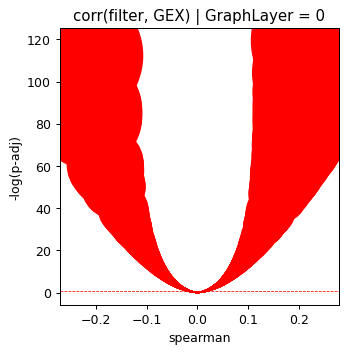

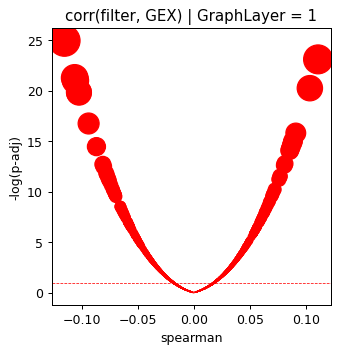

In [98]:
rcParams["figure.figsize"] = 4, 4
rcParams["figure.dpi"] = 90

for optimize_log_dynamic, grp in res.groupby("opt_log_dynamic"):
    grp["minus_log10_pval"] = -np.log10(grp["p_val"])
    grp = grp.sort_values("matched")
    plt.scatter(
        grp["spearman"],
        grp["minus_log10_pval"],
        s=np.power(grp["minus_log10_pval"], 2),
        color=np.where(grp["matched"], "red", "blue"),
    )
    plt.ylabel("-log(p-adj)")
    plt.xlabel("spearman")
    plt.title("corr(filter, GEX) | GraphLayer = %i" % optimize_log_dynamic)
    plt.axhline(1, ls="--", color="red", lw=0.6)
    plt.show()

In [99]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

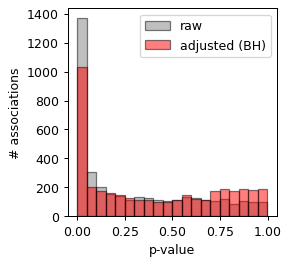

In [100]:
rcParams["figure.figsize"] = 3, 3
rcParams["figure.dpi"] = 90
plt.hist(res["p_val"], color="gray", bins=20, label="raw", alpha=0.5, edgecolor="black")
plt.hist(res["p_adj"], color="red", bins=20, label="adjusted (BH)", alpha=0.5, edgecolor="black")
plt.xlabel("p-value")
plt.legend()
plt.ylabel("# associations")

In [101]:
res[res["p_adj"] < 0.05]

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman         p_val module_name         p_adj            k
9             1            False             2      Pdx1     True  0.032841  3.006220e-03        HD/2  1.455961e-02       Pdx1_2
11            1            False             2      Pax4     True -0.033665  2.353099e-03        HD/2  1.184219e-02       Pax4_2
18            7            False             8       Arx     True -0.081863  1.295229e-13        HD/8  3.845833e-12        Arx_8
19            7            False             8    Arxes2     True  0.034815  1.657269e-03        HD/8  8.787167e-03     Arxes2_8
20            9            False            10  Hnf1aos1     True  0.035551  1.317555e-03       HD/10  7.163043e-03  Hnf1aos1_10
...         ...              ...           ...       ...      ...       ...           ...         ...           ...          ...
3842        262             True           263    Tfap2c     True  0.027537  1.285757e-02     TFAP2/2  4.823149e-02   Tfap2c_263
3847        264             True           265      Ctcf     True  0.046348  2.806301e-05        CTCF  2.391241e-04     Ctcf_265
3849        267             True           268     Plag1     True -0.028093  1.115049e-02       PLAG1  4.317042e-02    Plag1_268
3855        280             True           281      Pax6     True -0.080454  3.368429e-13       PAX/1  9.490611e-12     Pax6_281
3856        280             True           281   Pax6os1     True -0.041961  1.495984e-04       PAX/1  1.075326e-03  Pax6os1_281

[1033 rows x 10 columns]

In [102]:
pval_thr = 1e-5
sel_genes = set(list(res[res["p_adj"] < pval_thr]["gene_name"]))

In [103]:
log_act = ad.obsm["log_activities"].copy()

In [104]:
log_act.shape

(8161, 288)

In [105]:
cols_act = ["intercept", "dinuc_bias"] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [106]:
log_act

intercept  dinuc_bias          HD/1      HD/2      HD/3      HD/4      HD/5      HD/6      HD/7      HD/8  ...   GMEB2/2   GMEB2/3     FOX/9     SIX/2     PAX/1     PAX/2  PAX-halfsite       AHR  KLF/SP/3    ZSCAN4
AAACAGCCAACAGCCT-1-0  3.806271e-08    0.000003  7.695544e-05  0.000185  0.000027  0.000018  0.000150  0.000090  0.000008  0.000290  ...  0.000683  0.000745  0.000040 -0.000298  0.000297  0.000039      0.000093  0.002540 -0.000023  0.000095
AAACAGCCAACCCTCC-1-0 -1.162185e-07   -0.000003  4.249436e-07 -0.001115 -0.000109 -0.000263 -0.000553 -0.000185 -0.001000 -0.002746  ... -0.000548 -0.005312 -0.000712 -0.001427 -0.005037 -0.000265     -0.002616 -0.003395 -0.000373 -0.000473
AAACAGCCACTAAGCC-1-0  1.481323e-06   -0.000031  4.224365e-04  0.061922  0.004885  0.001461  0.002665  0.008734  0.030506 -0.058731  ... -0.048243  0.090099  0.075321  0.071688  0.167776  0.009557      0.061679 -0.104413  0.061235 -0.030773
AAACAGCCAGGATAAC-1-0 -2.535439e-08   -0.000002 -6.218390e-06 -0.000374 -0.000033 -0.000034 -0.000129 -0.000039 -0.000187 -0.000504  ... -0.000163 -0.000923 -0.000504 -0.000577 -0.000655 -0.000044     -0.000708 -0.002082  0.000082 -0.000144
AAACAGCCATAAAGCA-1-0  1.866635e-07    0.000009  1.157708e-04  0.001055  0.000114  0.000441  0.000247  0.000247  0.000514  0.003035  ...  0.002118  0.002020  0.003678  0.002987  0.003853  0.000299      0.001518  0.003987  0.001712  0.000473
...                            ...         ...           ...       ...       ...       ...       ...       ...       ...       ...  ...       ...       ...       ...       ...       ...       ...           ...       ...       ...       ...
TTTGTGTTCACGAATC-1-1 -3.571261e-08   -0.000003 -2.040713e-05 -0.000369 -0.000042 -0.000082 -0.000164 -0.000066 -0.000259 -0.000607  ... -0.000259 -0.001202 -0.000679 -0.000618 -0.000922 -0.000043     -0.000762 -0.001915 -0.000268 -0.000198
TTTGTGTTCGAGCTAT-1-1 -3.510256e-08   -0.000002  2.103153e-05 -0.000582 -0.000046 -0.000057 -0.000249 -0.000077 -0.000564 -0.001008  ... -0.000085 -0.001882 -0.000534 -0.001164 -0.000909 -0.000017     -0.001656 -0.002895 -0.000303 -0.000225
TTTGTGTTCTCAATGA-1-1 -4.718245e-08   -0.000003 -3.709015e-05 -0.000300 -0.000047 -0.000153 -0.000134 -0.000069 -0.000327 -0.000638  ... -0.000368 -0.001265 -0.000826 -0.000719 -0.001065 -0.000046     -0.000662 -0.001764 -0.000471 -0.000174
TTTGTTGGTATTGAGT-1-1 -3.771812e-08   -0.000003 -1.994044e-05 -0.000378 -0.000042 -0.000116 -0.000139 -0.000064 -0.000266 -0.000597  ... -0.000290 -0.001464 -0.000433 -0.000576 -0.000906 -0.000041     -0.000935 -0.001973 -0.000344 -0.000205
TTTGTTGGTTGTTGCT-1-1 -4.738262e-08   -0.000003 -3.046263e-05 -0.000377 -0.000069 -0.000157 -0.000204 -0.000086 -0.000439 -0.001027  ... -0.000442 -0.001635 -0.000916 -0.000986 -0.000826 -0.000029     -0.001108 -0.002171 -0.000469 -0.000263

[8161 rows x 288 columns]

In [107]:
import anndata


ad_act = anndata.AnnData(log_act)

ad_act.obsm["X_umap"] = ad.obsm["X_umap"]

ad_act.obs = ad.obs

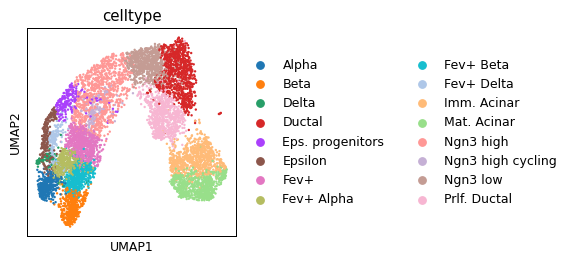

In [108]:
sc.pl.umap(ad_act, color="celltype")

Rank genes groups using the annotation

In [109]:
sc.tl.rank_genes_groups(ad_act, "celltype")
rkg_df = []
for ct in ad_act.obs["celltype"].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2["celltype"] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df["module_name"] = rkg_df["names"].map(anno.set_index("Cluster_ID")["Name"].to_dict())
rkg_df["module_name"] = np.where(~pd.isnull(rkg_df["module_name"]), rkg_df["module_name"], rkg_df["names"])
rkg_df.head()

Fev+ Alpha
Fev+
Ngn3 high
Eps. progenitors
Ngn3 low
Fev+ Beta
Ductal
Fev+ Delta
Imm. Acinar
Alpha
Prlf. Ductal
Epsilon
Ngn3 high cycling
Beta
Delta
Mat. Acinar


names    scores  logfoldchanges     pvals  pvals_adj    celltype module_name
0     GCM  0.910906        3.654080  0.362733   0.627158  Fev+ Alpha         GCM
1  ZNF431  0.515329        4.179523  0.606397   0.835609  Fev+ Alpha      ZNF431
2   NR/15  0.422957             NaN  0.672541   0.905102  Fev+ Alpha       NR/15
3   HD/16  0.403896             NaN  0.686494   0.916561  Fev+ Alpha       HD/16
4   ARI5B  0.402635             NaN  0.687421   0.916561  Fev+ Alpha       ARI5B

Get top modules

In [110]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index("names")["module_name"].to_dict())

In [111]:
sc.tl.rank_genes_groups(ad_act, "celltype")

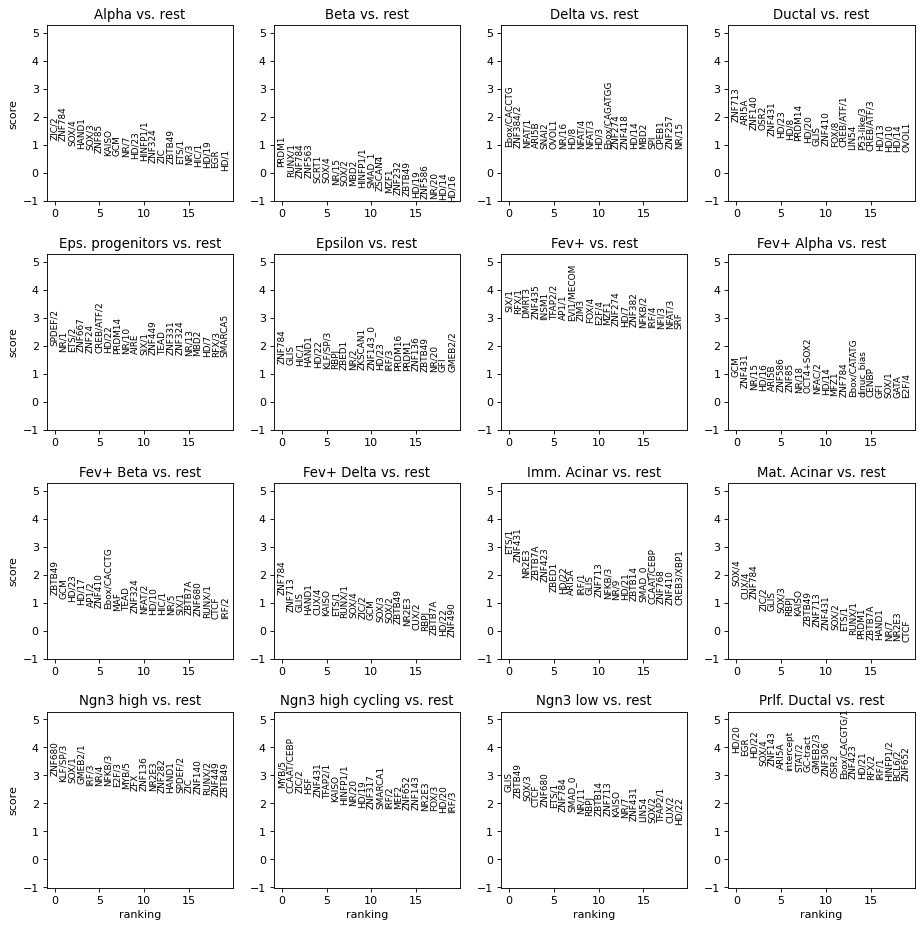

In [112]:
rcParams["figure.figsize"] = 3.5, 3.5
rcParams["figure.dpi"] = 80
sc.pl.rank_genes_groups(ad_act)

In [113]:
set(res[(res["p_adj"] < 1e-5)]["k"])

{'Araf_248',
 'Arc_248',
 'Arcn1_248',
 'Arel1_248',
 'Arf3_248',
 'Arf5_248',
 'Arf6_248',
 'Arfgap1_248',
 'Arfgap3_248',
 'Arfgef1_248',
 'Arfgef2_248',
 'Arfgef3_248',
 'Arhgap10_248',
 'Arhgap11a_248',
 'Arhgap18_248',
 'Arhgap19_248',
 'Arhgap21_248',
 'Arhgap24_248',
 'Arhgap26_248',
 'Arhgap28_248',
 'Arhgap32_248',
 'Arhgap35_248',
 'Arhgap36_248',
 'Arhgap42_248',
 'Arhgap5_248',
 'Arhgap6_248',
 'Arhgdig_248',
 'Arhgef11_248',
 'Arhgef12_248',
 'Arhgef19_248',
 'Arhgef26_248',
 'Arhgef38_248',
 'Arhgef39_248',
 'Arhgef40_248',
 'Arhgef5_248',
 'Arhgef6_248',
 'Arhgef7_248',
 'Arhgef9_248',
 'Arid1b_248',
 'Arid2_248',
 'Arid3b_248',
 'Arid4b_248',
 'Arih1_248',
 'Arih2_248',
 'Arl13b_248',
 'Arl15_248',
 'Arl3_248',
 'Arl4a_248',
 'Arl4c_248',
 'Arl6ip1_248',
 'Arl6ip4_248',
 'Arl8a_248',
 'Armc4_248',
 'Armc8_248',
 'Armc9_248',
 'Armh3_248',
 'Arnt_248',
 'Arpc1a_248',
 'Arpc1b_248',
 'Arpc2_248',
 'Arpc5_248',
 'Arpc5l_248',
 'Arpp19_248',
 'Arrdc4_248',
 'Arsa_248',
 'Ar

In [114]:
res[res["module_name"].str.contains("HD")].sort_values("p_adj")

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman         p_val module_name         p_adj          k
42           20            False            21      Pdx1     True  0.085723  8.687087e-15       HD/16  2.865996e-13    Pdx1_21
18            7            False             8       Arx     True -0.081863  1.295229e-13        HD/8  3.845833e-12      Arx_8
1946          1             True             2      Isl1     True -0.075389  9.154130e-12        HD/2  2.222323e-10     Isl1_2
25           11            False            12      Pbx1     True  0.065727  2.795715e-09       HD/12  5.042739e-08    Pbx1_12
1971         18             True            19     Meis1     True  0.053219  1.506326e-06       HD/14  1.680467e-05   Meis1_19
...         ...              ...           ...       ...      ...       ...           ...         ...           ...        ...
1973         20             True            21      Pbx2     True -0.002056  8.526826e-01       HD/16  9.218578e-01    Pbx2_21
1933          1             True             2    Dlx1as     True -0.001950  8.602075e-01        HD/2  9.268220e-01   Dlx1as_2
46           23            False            24    Arid3a     True -0.001547  8.888475e-01       HD/18  9.415344e-01  Arid3a_24
12            1            False             2    Arid3b     True  0.000642  9.537659e-01        HD/2  9.767940e-01   Arid3b_2
7             1            False             2      Mnx1     True -0.000469  9.662018e-01        HD/2  9.827507e-01     Mnx1_2

[68 rows x 10 columns]

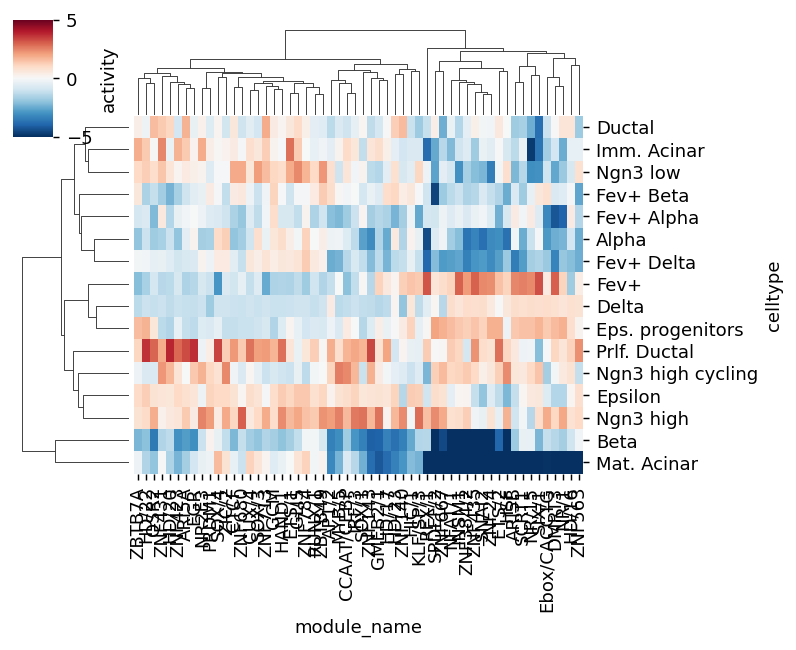

In [115]:
mod_names_best = set(rkg_df.sort_values("scores", ascending=False).groupby("celltype").head(5)["module_name"])
best = rkg_df[rkg_df["module_name"].isin(mod_names_best)]
rcParams["figure.dpi"] = 130
sns.clustermap(
    best.pivot(index="celltype", columns="module_name", values="scores"),
    cbar_kws={"label": "activity"},
    cmap="RdBu_r",
    vmin=-5,
    vmax=5,
    figsize=[6.2, 5],
    # dpi=100,
    xticklabels=True,
)

In [116]:
rna_tfs = rna_sel.to_df()[list(set(res["gene_name"]))]
rna_tfs["celltype"] = rna_sel.obs["celltype"]
mean_tfs = rna_tfs.groupby("celltype").mean()

act_tfs_df = ad_act.to_df()
act_tfs_df["celltype"] = ad_act.obs["celltype"]
mean_act_tf = act_tfs_df.groupby("celltype").mean()

In [117]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype, columns=["module_name", "gene_name", "cell_type", "pearsonr", "p_val"])
corr = corr.sort_values("pearsonr", ascending=False)

0 288
50 288
100 288
150 288
200 288
250 288


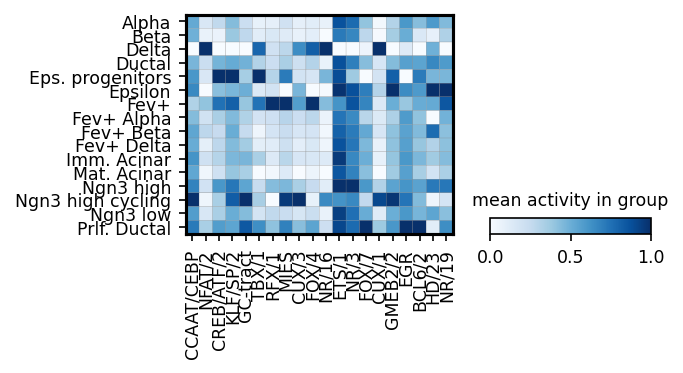

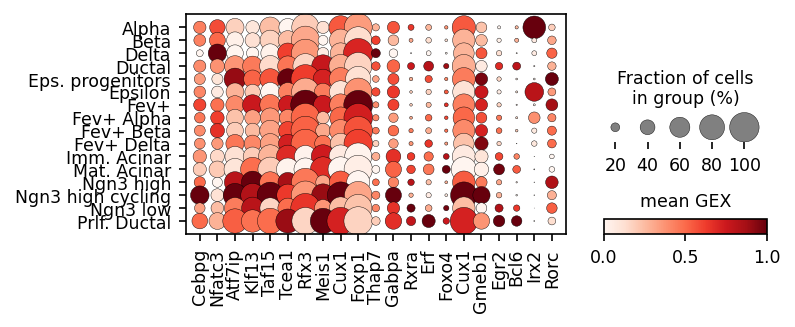

In [118]:
rcParams['figure.dpi'] = 150
# activators
module_names = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            show=False,
            var_names=module_names,
            figsize=[4, 1.9],
            standard_scale='var',
            colorbar_title='mean activity in group')

plt.savefig('../../../output/filter_activities_pancreatic_endocrinogenesis.pdf')
plt.show()

sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              standard_scale='var',
              show=False,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.9])

plt.savefig('../../../output/gene_expression_pancreatic_endocrinogenesis.pdf')
plt.show()



In [119]:
module_names

166     CCAAT/CEBP
1467        NFAT/2
158     CREB/ATF/2
1517      KLF/SP/2
1546      GC-tract
602          TBX/1
1712         RFX/1
276           MIES
37           CUX/3
1358         FOX/4
109          NR/16
1449         ETS/1
70            NR/3
1621         FOX/7
36           CUX/1
1920       GMEB2/2
1527           EGR
1634        BCL6/2
1685         HD/23
132          NR/19
Name: module_name, dtype: object

In [120]:
module_names

166     CCAAT/CEBP
1467        NFAT/2
158     CREB/ATF/2
1517      KLF/SP/2
1546      GC-tract
602          TBX/1
1712         RFX/1
276           MIES
37           CUX/3
1358         FOX/4
109          NR/16
1449         ETS/1
70            NR/3
1621         FOX/7
36           CUX/1
1920       GMEB2/2
1527           EGR
1634        BCL6/2
1685         HD/23
132          NR/19
Name: module_name, dtype: object

In [121]:
module_names.map(res.set_index('module_name')['filter_id'].to_dict())

166      51
1467     98
158      49
1517    108
1546    112
602      69
1712    246
276      68
37       14
1358     78
109      44
1449     97
70       31
1621    163
36       13
1920    276
1527    110
1634    169
1685    203
132      47
Name: module_name, dtype: int64

In [122]:
module_names

166     CCAAT/CEBP
1467        NFAT/2
158     CREB/ATF/2
1517      KLF/SP/2
1546      GC-tract
602          TBX/1
1712         RFX/1
276           MIES
37           CUX/3
1358         FOX/4
109          NR/16
1449         ETS/1
70            NR/3
1621         FOX/7
36           CUX/1
1920       GMEB2/2
1527           EGR
1634        BCL6/2
1685         HD/23
132          NR/19
Name: module_name, dtype: object

In [123]:
anno[anno['Name'].str.contains('ETS')]

Cluster_ID   Name  DBD           Seed_motif  Total_width  Consensus_left  Consensus_right  Cluster_size Name_unique
36          98  ETS/1  ETS            EHF_ETS_1           25               7               17            71       ETS/1
37          96  ETS/2  ETS  EHF_HUMAN.H11MO.0.B           18               3               14            24       ETS/2

In [124]:
name_by_filter_id = meta["archetypes_name"].to_dict()
name_by_filter_id[1]

'HD/1'

In [125]:
test_names = list(anno.sort_values('Cluster_ID')['Name'])[:1]
print(test_names)

pd.Series(test_names).map(res.set_index('module_name')['filter_id'].to_dict())

['HD/1']


0   NaN
dtype: float64

In [126]:
filter_id_by_name = {v: k for k, v in zip(name_by_filter_id.keys(), name_by_filter_id.values())}

SOX/3


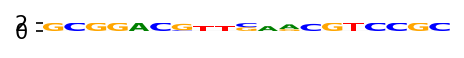

In [127]:
for k in list(anno.sort_values('Cluster_ID')['Name']):
    if k != 'SOX/3':
        continue
    print(k)
    mb.pl.logo(
        model,
        title=False,
        xticks=False,
        rowspan_dinuc=0,
        rowspan_mono=1,
        n_rows=40,
        log_odds=True,
        # stop_at=11,
        show=False,
        # n_rows=len(res.head(20).index),
        n_cols=1,
        order=pd.Series([k]).map(filter_id_by_name) + 2,
    )  # n_cols=len(reduced_groups))
    # plt.tight_layout()
    plt.show()

In [128]:
custom_names = pd.Series(['MYB/5', 'MYB/1', 'FOX/4', 'NR/20', 'TBX/1', 'ETS/1', 'YY1', 'STAT/1', 'NR/17', 'HD/14'])
# custom_names = pd.Series(['FOX/4',])
custom_names.map(res.set_index('module_name')['filter_id'].to_dict()),

(0    251
 1    252
 2     78
 3    247
 4     69
 5     97
 6    144
 7    166
 8     45
 9     18
 dtype: int64,)

0    251
1    252
2     78
3    247
4     69
5     97
6    144
7    166
8     45
9     18
dtype: int64


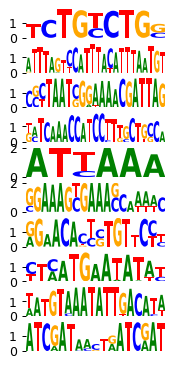

In [129]:
print(custom_names.map(res.set_index('module_name')['filter_id'].to_dict()))
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    log_odds=True,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=custom_names.map(filter_id_by_name) + 2,
)  # n_cols=len(reduced_groups))
# plt.tight_layout()

plt.savefig('../../../output/motif_pancreatic_endocrinogenesis_publication.pdf')
plt.show()


0    261
1     79
dtype: int64


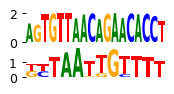

In [130]:
custom_names = pd.Series(['GLI', 'FOX/5'])

print(custom_names.map(res.set_index('module_name')['filter_id'].to_dict()))
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    log_odds=True,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=custom_names.map(filter_id_by_name) + 2,
)  # n_cols=len(reduced_groups))
# plt.tight_layout()

plt.savefig('../../../output/motif_pancreatic_neurogenesis_publication_subset.pdf')
plt.show()


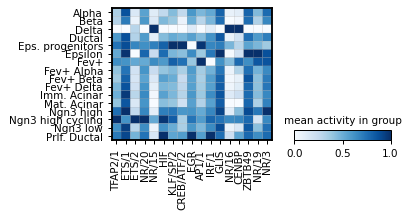

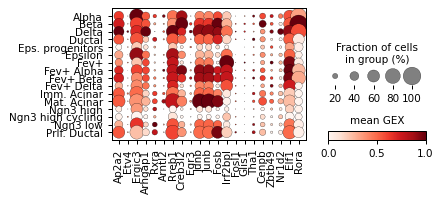

In [131]:
# repressors
module_names = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.9],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              standard_scale='var',
              var_names=gene_names,
              figsize=[4.5, 1.9])



In [132]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

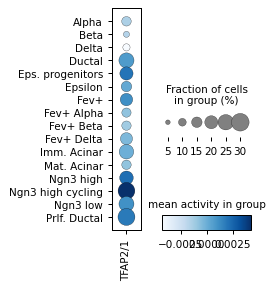

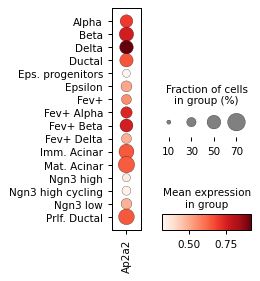

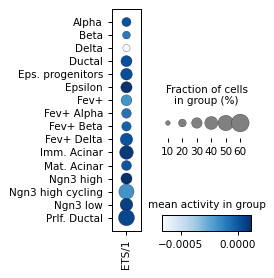

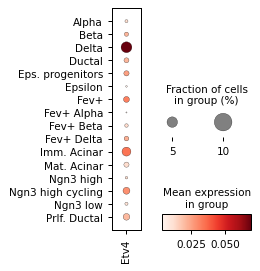

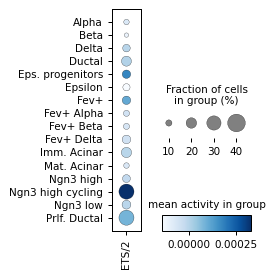

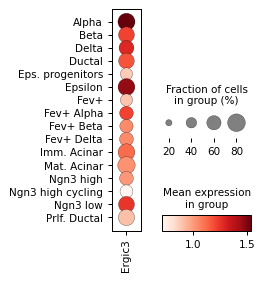

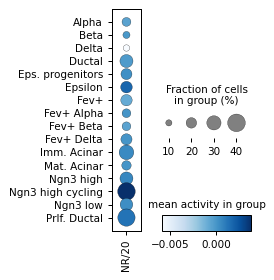

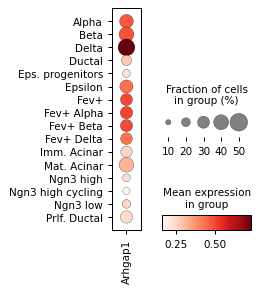

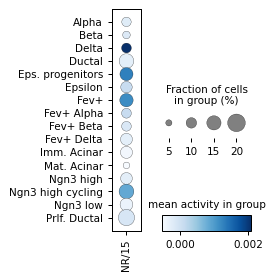

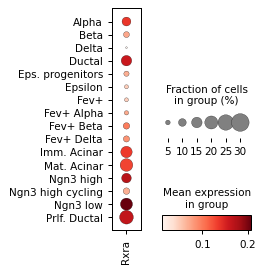

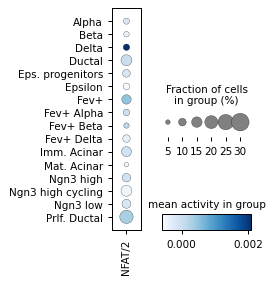

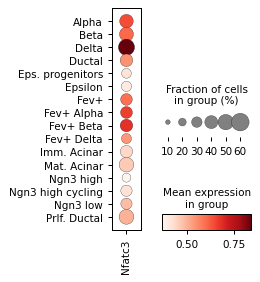

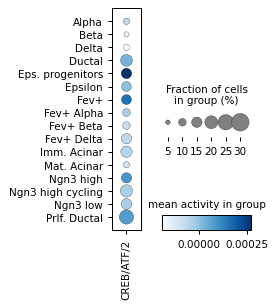

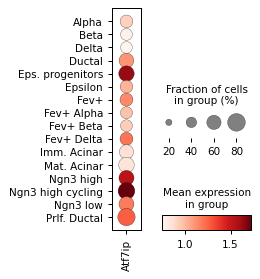

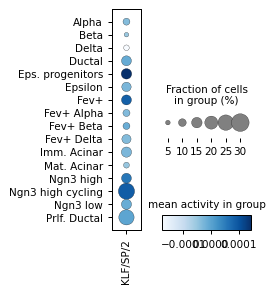

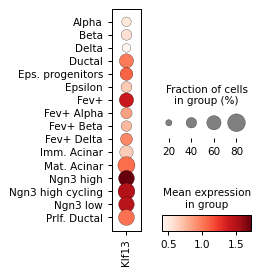

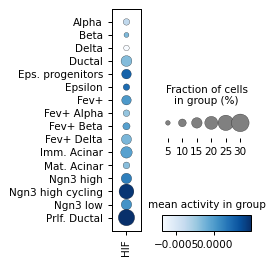

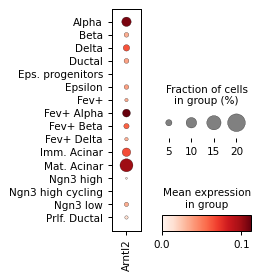

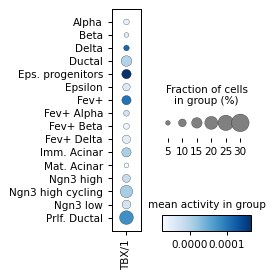

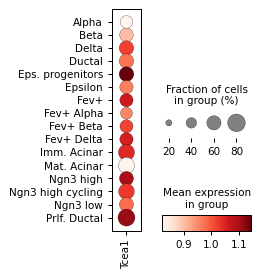

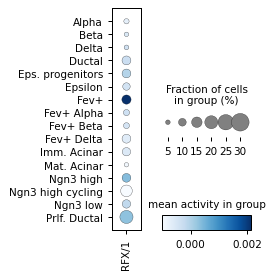

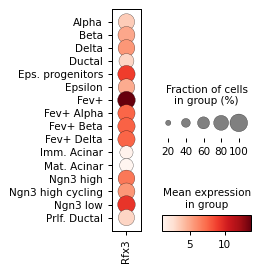

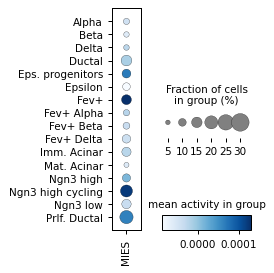

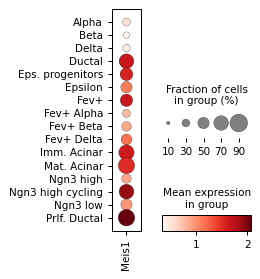

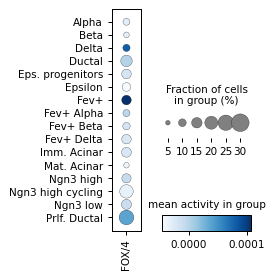

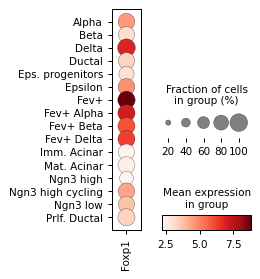

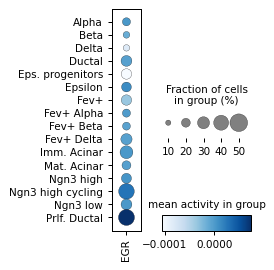

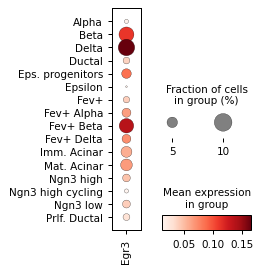

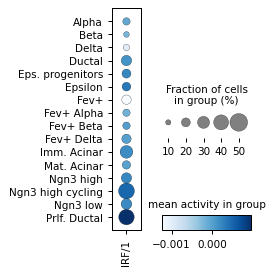

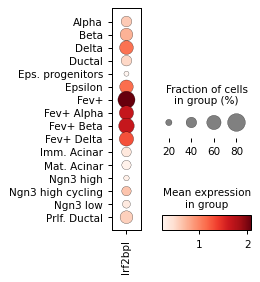

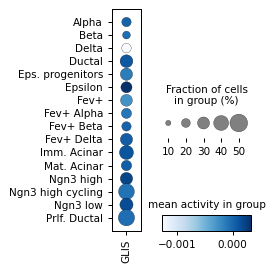

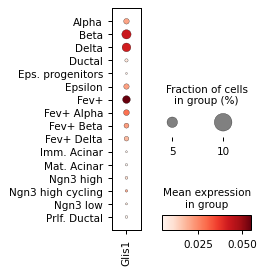

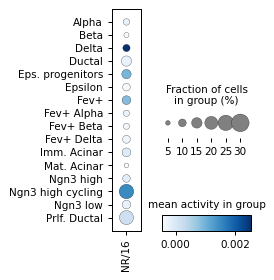

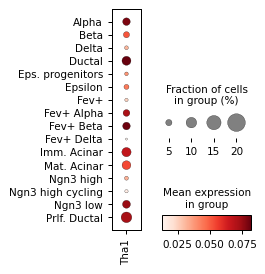

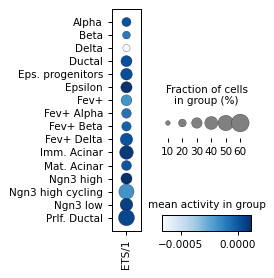

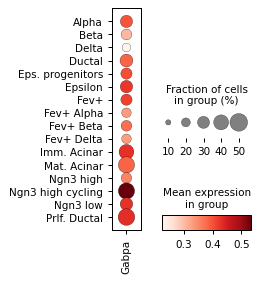

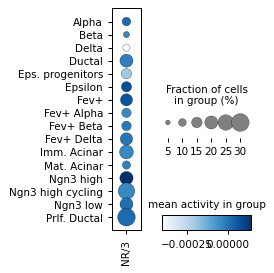

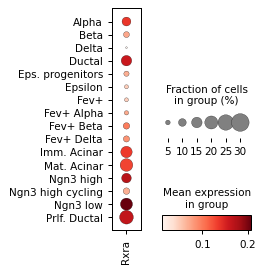

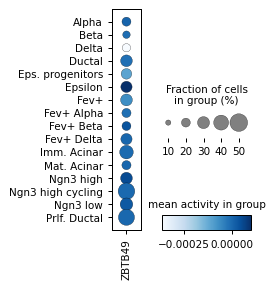

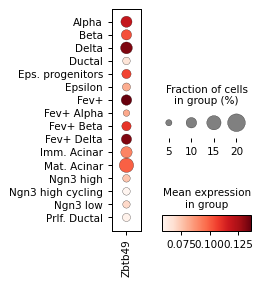

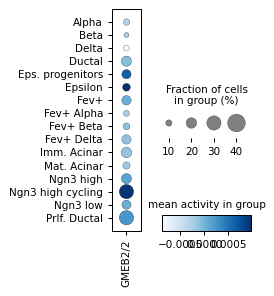

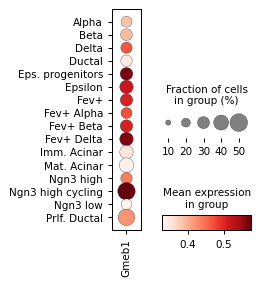

In [133]:
for ri, r in corr.sort_values("p_val").groupby("cell_type").head(3).iterrows():
    # ad_act.obs['HD/2'] = log_act['HD/2']
    sc.pl.dotplot(
        ad_act,
        groupby="celltype",
        cmap="Blues",
        var_names=r["module_name"],
        figsize=[2, 3.2],
        colorbar_title="mean activity in group",
    )
    sc.pl.dotplot(rna_sel, groupby="celltype", var_names=r["gene_name"], figsize=[2, 3.2])

### Filter activities versus graph activities

In [134]:
A = model.get_log_activities()
sum_A = A.abs().sum(axis=1).cpu().detach().numpy()
A = A.squeeze(0)
print(A.shape)

torch.Size([288, 8161])


In [135]:
# this function assesses the contributions of A on the graph
indices, contributions, max_eig = mb.tl.compute_contributions(A.cpu(), C.cpu(),  D.cpu())

contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=["index"])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



index
count  288.000000
mean     0.377668
std      0.044241
min      0.277876
25%      0.344783
50%      0.377110
75%      0.407360
max      0.496437

Percentage of non-zero entries of the filter matrix A: 100.0 %


<Figure size 1000x500 with 0 Axes>

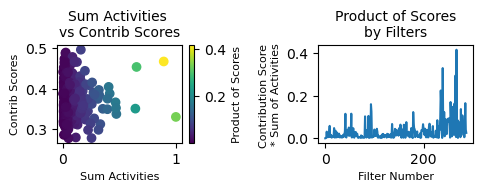

In [136]:
from matplotlib.pyplot import rcParams

rcParams["figure.dpi"] = 100
plt.figure(figsize=(10, 5))

print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")

mb.pl.filter_contrib_simple(contributions_normalized, A.cpu())

In [137]:
# normalize the data, and look at summary stats
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A.T, columns=["sum_A"])
sum_A_df.describe()

sum_A
count  288.000000
mean     5.957136
std      8.597739
min      0.000547
25%      1.099398
50%      2.910393
75%      7.284939
max     68.284973

In [138]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.cpu().abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=["contribution_times_activities"])
contrib_times_activities_df.describe()

contribution_times_activities
count                     288.000000
mean                        2.240525
std                         3.305919
min                         0.000212
25%                         0.422303
50%                         1.031057
75%                         2.731761
max                        28.479479

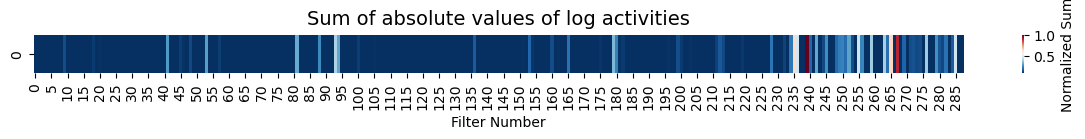

In [139]:
sum_A = A.cpu().abs().sum(axis=1)
sum_A_normalized = sum_A / sum_A.max()
mb.pl.filter_contrib_heatmap(sum_A_normalized, title='Sum of absolute values of log activities', score="Normalized Sum")

In [140]:
# this function assesses the contributions of A on the graph
indices, contributions, max_singular_value = mb.tl.compute_contributions(A.cpu(), C.cpu(), D.cpu(), use_hadamard=False)
contributions_normalized = torch.abs(contributions) / max_singular_value

(array([  9,  18,  20,  41,  45,  46,  48,  53,  57,  81,  88,  93,  94,
       100, 105, 136, 150, 151, 153, 154, 160, 162, 165, 175, 179, 180,
       181, 182, 196, 199, 200, 203, 211, 212, 213, 219, 228, 232, 233,
       234, 235, 236, 239, 240, 242, 244, 245, 248, 249, 250, 251, 252,
       253, 255, 256, 259, 263, 264, 265, 267, 269, 271, 272, 273, 274,
       276, 279, 280, 281, 282, 284, 285]),)
[136, 160, 162, 181, 199, 212, 219, 228, 234, 248, 255, 256, 259, 263, 265, 267, 269, 271, 279, 281]
tensor(0.25)


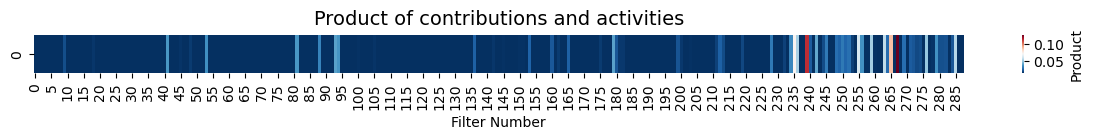

In [141]:
contrib_np = contributions_normalized.detach().numpy()
sum_A_np = sum_A_normalized.detach().numpy()
rel_idcC = np.where(contrib_np >= np.percentile(contrib_np, 75))
rel_idcA = np.where(sum_A_np >= np.percentile(sum_A_np, 75))
print(rel_idcA)
print([x for x in rel_idcC[0] if x in rel_idcA[0]])

contrib_activites_prod = contributions_normalized * sum_A_normalized
print(sum(contrib_activites_prod >= np.sort(contrib_activites_prod.detach().numpy())[3*len(contrib_activites_prod) // 4])/len(contrib_activites_prod))
mb.pl.filter_contrib_heatmap(contrib_activites_prod, title="Product of contributions and activities", score="Product")

Percentage of non-zero entries of the filter matrix A: 100.0 %


<Figure size 1000x500 with 0 Axes>

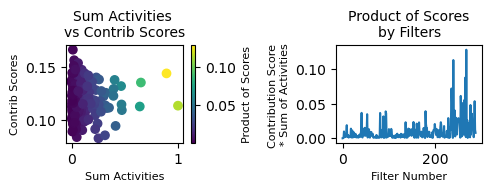

In [142]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 5))


print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")

mb.pl.filter_contrib_simple(contributions_normalized, A.cpu(), 'filter_contrib_plot.pdf')

plt.savefig('../../../output/contrib_scores_graph_pancreatic_endocrinogenesis.pdf')

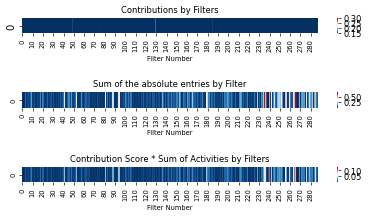

In [147]:

from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 60

mb.pl.contrib_heatmaps(A.detach().cpu(), C.detach().cpu(), D.detach().cpu(), use_hadamard=False, save_pdf=True)

In [148]:
anno[anno['Name'] == 'TFAP2/1']

Cluster_ID     Name   DBD            Seed_motif  Total_width  Consensus_left  Consensus_right  Cluster_size Name_unique
215         264  TFAP2/1  TFAP  AP2A_HUMAN.H11MO.0.A           15               3               12            24     TFAP2/1

In [149]:
# grnpedia associations
ttrust = pd.read_csv('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',
                     sep='\t',
                     header=None)
ttrust.columns = ['tf', 'target', 'role', 'ref']
ttrust = ttrust.groupby(['tf', 'role']).size().reset_index().pivot(index='tf', columns='role', values=0).fillna(0)
ttrust['consensus'] = np.where((ttrust['Activation'] > 0) & (ttrust['Repression'] == 0), 'red',
                               np.where((ttrust['Repression'] > 0) & (ttrust['Activation'] == 0), 'blue', 'purple'))

In [150]:
res[res['module_name'] == 'SOX/3']

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman         p_val module_name         p_adj         k
1403         91            False            92     Sox13     True -0.019356  8.037954e-02       SOX/3  1.974952e-01  Sox13_92
1404         91            False            92      Sox8     True  0.013017  2.396776e-01       SOX/3  4.317106e-01   Sox8_92
1405         91            False            92     Sox30     True  0.022332  4.365840e-02       SOX/3  1.264612e-01  Sox30_92
1406         91            False            92     Sox11     True -0.000002  9.998756e-01       SOX/3  9.998756e-01  Sox11_92
1407         91            False            92     Sox10     True  0.004463  6.868651e-01       SOX/3  8.237248e-01  Sox10_92
1408         91            False            92     Sox12     True  0.004646  6.747168e-01       SOX/3  8.159169e-01  Sox12_92
1409         91            False            92      Sox9     True  0.112574  1.970287e-24       SOX/3  1.311260e-22   Sox9_92
3333         91             True            92     Sox13     True -0.003547  7.486992e-01       SOX/3  8.619085e-01  Sox13_92
3334         91             True            92      Sox8     True  0.002815  7.992993e-01       SOX/3  8.881103e-01   Sox8_92
3335         91             True            92     Sox30     True -0.003407  7.582867e-01       SOX/3  8.665619e-01  Sox30_92
3336         91             True            92     Sox11     True  0.024678  2.578970e-02       SOX/3  8.429149e-02  Sox11_92
3337         91             True            92     Sox10     True  0.011439  3.014702e-01       SOX/3  5.088216e-01  Sox10_92
3338         91             True            92     Sox12     True -0.023356  3.486919e-02       SOX/3  1.065360e-01  Sox12_92
3339         91             True            92      Sox9     True  0.037916  6.127002e-04       SOX/3  3.724445e-03   Sox9_92

In [151]:
# res_sel[res_sel['module_name'] == 'SOX/3']

In [152]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 80

# unsqueeze the data to make it compatible with the heatmap function
sum_A_norm = sum_A_norm.reshape(1,-1)
contrib_times_activities = contrib_times_activities.reshape(1,-1)

In [154]:
!pip install adjustText

In [155]:
from adjustText import adjust_text

In [156]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 135
rcParams['pdf.fonttype'] = 42

def delta_models(model_by_logdynamic):
    model = model_by_logdynamic[True]
    log_act1 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act1 = pd.DataFrame(log_act1.detach().cpu().numpy())

    model = model_by_logdynamic[False]
    log_act2 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act2 = pd.DataFrame(log_act2.detach().cpu().numpy())

    d = log_act1.mean(axis=0) - log_act2.mean(axis=0)
    # d.index = ad.obs_names
    return d

# graph = True - graph = False
delta_model = delta_models(model_by_logdynamic)
delta_model
delta_model = delta_model[2:]
delta_model.index = range(len(delta_model))
delta_model.index += 1
delta_model.index = delta_model.index.map(name_by_filter_id)
delta_model

res['act_change'] = res['module_name'].map(delta_model.to_dict())
res['k'] = res['module_name'] + ':' + res['gene_name']
res['graph_score'] = res['filter_id'].map({i : contrib_times_activities[0][i + 2] for i in range(len(contrib_times_activities[0]) - 2)})
res['z'] = np.sqrt((res['graph_score'] ** 2) * (-np.log(res['p_adj'] + 1e-10)) ** 2)


In [157]:
# only show weights with Graph Layer on
res_sel = res.copy() # [res['opt_log_dynamic']]


In [158]:
res.shape, res_sel.shape

((3860, 13), (3860, 13))

PROX1:Prox1 (0.1059767525471204, 0.028886475849371568) 0.16746491193771362 purple
CCAAT/CEBP:Dbpht2 (0.08536277658217145, -0.10255250768984316) 0.10485882312059402 gray
MYB/2:Mybl1 (0.07734918164531444, 0.05428451893348915) 0.12227752804756165 purple
NR/11:Nr5a2 (0.06523281984085992, 0.03952495182055314) 0.21196624636650085 red
GLI:Zbtb7c (0.06397115296691377, -0.05706246215981071) 0.09551192820072174 gray
SOX/3:Sox9 (0.05609969940570946, 0.03852411756917732) 0.1335025131702423 purple
TFAP2/1:Ap2a1 (0.055899889740226597, -0.019106576198307353) 0.15999287366867065 gray
GRHL:Grhl2 (0.03513197853410249, 0.04331429681436185) 0.08097979426383972 gray
SOX/4:Sox4 (0.03209149718337514, 0.044195799745043826) 0.08338265866041183 purple
FOX/5:Foxo1 (0.028284020278165116, -0.05766508859818134) 0.07688487321138382 purple


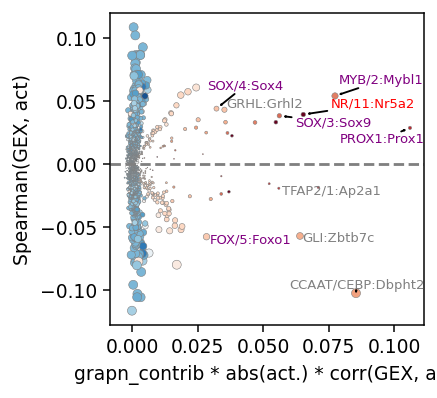

In [159]:


ax = plt.subplot()
cmap = sns.color_palette('RdBu_r', as_cmap=True)


res_sel = res_sel.sort_values('z', ascending=False) # .drop_duplicates('module_name')
# res_sel = res_sel.drop_duplicates('module_name')

# res_sel['x'] = np.log((res_sel['graph_score'] + 1) * (res_sel['act_change'].abs() + 1))
res_sel['x'] = res_sel['graph_score'] * res_sel['act_change'].abs() * res_sel['spearman'].abs()
# res_sel['x'] = res_sel['act_change'].abs() * res_sel['spearman'].abs()

# general noise stacking of cells on x-y axes
sigma = 0.001
mu =0.00
# generate normally distributed samples
noise = sigma * np.random.randn(res_sel.shape[0]) + mu
res_sel['x'] = res_sel['x'] + noise
res_sel['spearman'] = res_sel['spearman'] + noise


edgecolors = res_sel['gene_name'].map(ttrust['consensus'].to_dict())
edgecolors = np.where(~pd.isnull(edgecolors), edgecolors, 'gray')
res_sel['edgecolors'] = edgecolors

for show_log_dynamic in [True,]:
    res_plot = res_sel[res_sel['opt_log_dynamic'] == show_log_dynamic]
    plt.scatter(res_plot['x'],            
                res_plot['spearman'],
                s=-np.log(res_plot['p_adj'] + 1e-10),
                cmap=cmap,
                lw=.3,
                marker='o' if show_log_dynamic else '^',
                edgecolors='gray',
                c=res_plot['act_change'])

    plt.axhline(y=0, ls='--', c='gray')
    plt.xlabel('grapn_contrib * abs(act.) * corr(GEX, act)')
    plt.ylabel('Spearman(GEX, act)')


    res_plot = res_plot.sort_values('x', ascending=False).drop_duplicates('module_name')
    texts = [] # [plt.text(x[i], y[i], 'Text%s' %i, ha='center', va='center') for i in range(len(x))]

    for ri, r in res_plot.head(10).iterrows():
        print(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), r['act_change'], r['edgecolors'])
        t = ax.annotate(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), fontsize=7, color=r['edgecolors'])
        texts.append(t)
    adjust_text(texts, arrowprops=dict(arrowstyle='->'))

plt.savefig('../../../output/graph_contribution_pancreatic_endocrinogesis.pdf')
plt.show()

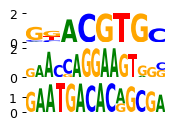

In [160]:
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    log_odds=True,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=pd.Series(['SOX/3', 'NR/11', 'CCAAT/CEBP']).map(res.set_index('module_name')['filter_id'].to_dict()),
)  # n_cols=len(reduced_groups))
# plt.tight_layout()

plt.savefig('../../../output/motif_pancreatic_endocrinogenesis.pdf')
plt.show()


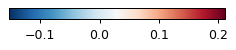

In [161]:
import pylab as pl
import numpy as np

a = np.array([[res_sel['act_change'].min(), res_sel['act_change'].max()]])
pl.figure(figsize=(3, .2))
img = pl.imshow(a, cmap="RdBu_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
pl.savefig("../../../output/graph_contribution_pancreatic_endocrinogenesis_cbar.pdf")

In [162]:
scv.tl.velocity_pseudotime(rna)
# scv.pl.scatter(rna, color="velocity_pseudotime", color_map="gnuplot")

computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [163]:
def running_mean(y_in, x_in, N_out=101, sigma=.05):
    '''
    Returns running mean as a Bell-curve weighted average at evenly spaced
    points. Does NOT wrap signal around, or pad with zeros.
    
    Arguments:
    y_in -- y values, the values to be smoothed and re-sampled
    x_in -- x values for array
    
    Keyword arguments:
    N_out -- NoOf elements in resampled array.
    sigma -- 'Width' of Bell-curve in units of param x .
    '''
    import numpy as np
    N_in = len(y_in)

    # Gaussian kernel
    x_out = np.linspace(np.min(x_in), np.max(x_in), N_out)
    x_in_mesh, x_out_mesh = np.meshgrid(x_in, x_out)
    gauss_kernel = np.exp(-np.square(x_in_mesh - x_out_mesh) / (2 * sigma**2))
    # Normalize kernel, such that the sum is one along axis 1
    normalization = np.tile(np.reshape(np.sum(gauss_kernel, axis=1), (N_out, 1)), (1, N_in))
    gauss_kernel_normalized = gauss_kernel / normalization
    # Perform running average as a linear operation
    y_out = gauss_kernel_normalized @ y_in

    return y_out, x_out

In [164]:
# prepare velocity pseudotime values for visualization
atac.obs['velocity_pseudotime'] = rna.obs['velocity_pseudotime'].values
ad.obs['velocity_pseudotime'] = atac.obs['velocity_pseudotime']

### Given a few potential genes, verify its association with chromatin targets

In [165]:
def plot_pseudotime(gene_name, filter_name, sigma_gex=.05, sigma_filter=.1, save=None):
    rcParams['figure.figsize'] = 3, 2
    gene_key = gene_name
    x = rna.obs['velocity_pseudotime']
    y = rna[:,rna.var_names==gene_key].X.A.flatten()
    y = np.log(y)
    y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_gex)
    plt.scatter(x, y, edgecolors=None, color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='green')
    plt.ylabel('')
    plt.title(gene_key)
    plt.ylabel('gene expression [log]')
    plt.xlabel('pseudotime')


    x = ad.obs['velocity_pseudotime']

    if save is not None:
        plt.savefig(save + '_gex.pdf')
    plt.show()
    filter_id = int(res[res['module_name'].str.contains(filter_name)]['filter_id'].values[0])

    y= act.T.numpy()[:,filter_id]
    # y = np.abs(y)
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_filter)
    # plt.scatter(x, y, edgecolors='black', color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='red')
    plt.ylabel('')
    plt.title('filter activities %s' % filter_name)
    plt.ylabel('filter activity')
    plt.xlabel('pseudotime')

    if save is not None:
        plt.savefig(save + '_filter.pdf')

    # plt.close()
    plt.show()


In [166]:
# plot_pseudotime('Foxa2', 'FOXA/1', sigma_gex=.01, sigma_filter=.1,
#                 save="../../../output/pancreas_mafa_bzip")


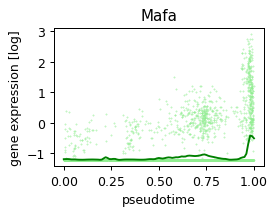

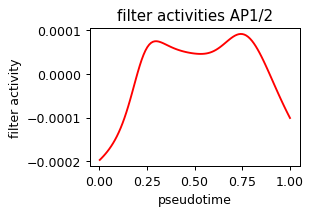

In [167]:
plot_pseudotime('Mafa', 'AP1/2', sigma_gex=.01, sigma_filter=.1,
                save="../../../output/pancreas_mafa_bzip")


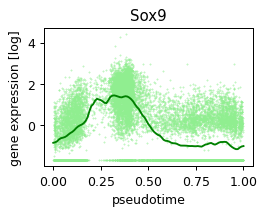

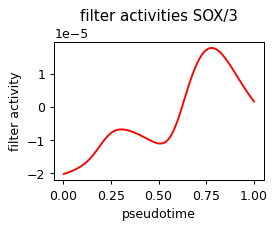

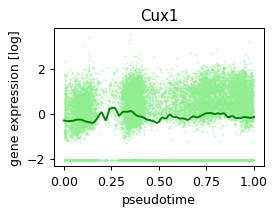

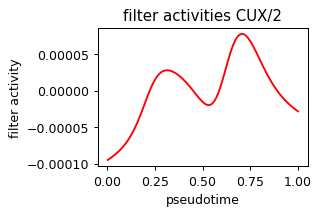

In [168]:
plt.rcParams["font.family"] = 'sans-serif' # None # "Arial"

plot_pseudotime('Sox9', 'SOX/3', sigma_gex=.01, sigma_filter=.1,
                save="../../../output/pancreas_sox9_sox3")

plot_pseudotime('Cux1', 'CUX/2', sigma_gex=.01, sigma_filter=.1,
                save="../../../output/pancreas_cux1_cux2")

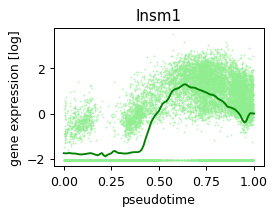

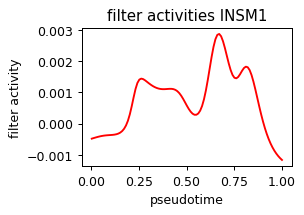

In [169]:
plot_pseudotime('Insm1', 'INSM1', sigma_gex=.01, sigma_filter=.05,
                save="../../../output/pancreas_CCAAT_CEBP_dbpht2")

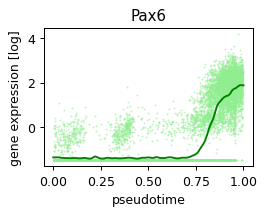

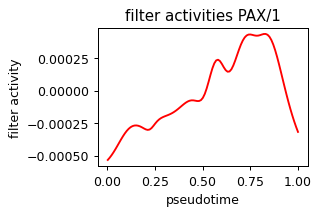

In [170]:
plot_pseudotime('Pax6', 'PAX/1', sigma_gex=.01, sigma_filter=.05,
                save="../../../output/pancreas_CCAAT_CEBP_dbpht2")

In [171]:
res

filter_id  opt_log_dynamic  archetype_id gene_name  matched  spearman         p_val   module_name         p_adj                  k  act_change  graph_score           z
0             1            False             2    Pou6f1     True -0.012835  2.463036e-01          HD/2  4.397465e-01        HD/2:Pou6f1   -0.033147     2.135972    1.754823
1             1            False             2    Pou6f2     True -0.004708  6.706317e-01          HD/2  8.131867e-01        HD/2:Pou6f2   -0.033147     2.135972    0.441707
2             1            False             2    Nkx6-1     True  0.019021  8.575862e-02          HD/2  2.067634e-01        HD/2:Nkx6-1   -0.033147     2.135972    3.366677
3             1            False             2    Dlx1as     True -0.011318  3.066163e-01          HD/2  5.133309e-01        HD/2:Dlx1as   -0.033147     2.135972    1.424340
4             1            False             2     Lmx1b     True -0.011210  3.112775e-01          HD/2  5.183482e-01         HD/2:Lmx1b   -0.033147     2.135972    1.403565
...         ...              ...           ...       ...      ...       ...           ...           ...           ...                ...         ...          ...         ...
3855        280             True           281      Pax6     True -0.080454  3.368429e-13         PAX/1  9.490611e-12         PAX/1:Pax6    0.045139     4.515195  103.556830
3856        280             True           281   Pax6os1     True -0.041961  1.495984e-04         PAX/1  1.075326e-03      PAX/1:Pax6os1    0.045139     4.515195   30.861954
3857        282             True           283      Pax2     True -0.003662  7.408379e-01  PAX-halfsite  8.568437e-01  PAX-halfsite:Pax2    0.024079     4.426369    0.683873
3858        283             True           284       Ahr     True  0.023966  3.038693e-02           AHR  9.556552e-02            AHR:Ahr    0.099753    11.301592   26.535496
3859        284             True           285      Klf8     True -0.019348  8.050853e-02      KLF/SP/3  1.976863e-01      KLF/SP/3:Klf8   -0.028565     2.733040    4.430459

[3860 rows x 13 columns]

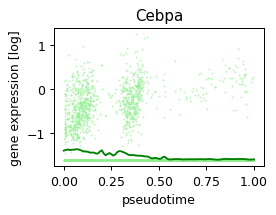

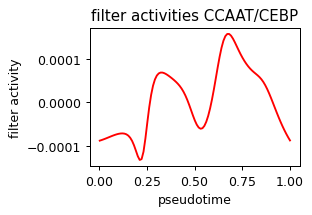

In [172]:
plot_pseudotime('Cebpa', 'CCAAT/CEBP', sigma_gex=.01, sigma_filter=.05,
                save="../../../output/pancreas_CCAAT_CEBP_dbpht2")

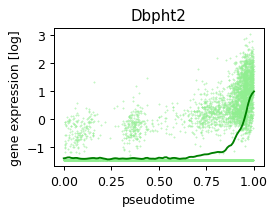

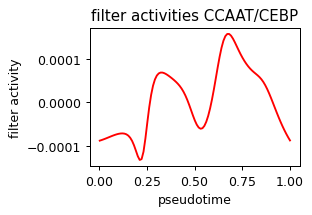

In [173]:
plot_pseudotime('Dbpht2', 'CCAAT/CEBP', sigma_gex=.01, sigma_filter=.05,
                save="../../../output/pancreas_CCAAT_CEBP_dbpht2")

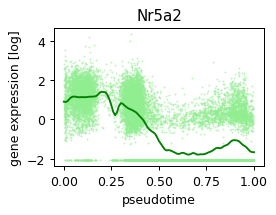

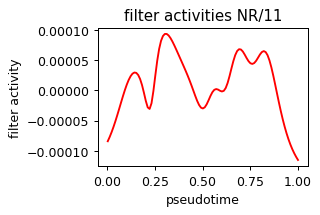

In [174]:
plot_pseudotime('Nr5a2', 'NR/11', sigma_gex=.01, sigma_filter=.05,
                save="../../../output/pancreas_nr5a2_nr11")

In [190]:
def plot_chromatin(filter_name, sigma_chrom,
                   group_key=None, key_sel=None,
                   q_thr=.95, show=True, save=None):
    res_sel = res[res['module_name'].str.contains(filter_name)]['filter_id']
    if res_sel.shape[0] == 0:
        print('not found')
        return None
    filter_id = int(res_sel.values[0])
    # print(filter_id)
    scores = binding_per_mode[:,filter_id]
    # filter scores across regions
    # plt.hist(scores)

    if group_key is not None and key_sel is not None:
        ad_sel = ad[ad.obs[group_key] == key_sel]
    else:
        ad_sel = ad
    # print('here')

    var_idx = np.argwhere(scores >= np.quantile(scores, q_thr)).flatten()
    var_names = ad_sel.var_names[var_idx]
    # print(q_thr, var_names.shape)
    # background with all peaks
    var_names_neg = ad_sel.var_names[~ad.var_names.isin(var_names)]
    
    x = ad_sel.obs['velocity_pseudotime']
    y = ad_sel[:,var_names].X.mean(axis=1).A.flatten()
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])
    y_mean, x_mean = running_mean(y, x, sigma=sigma_chrom)
    plt.scatter(x, y, edgecolors=None, color='lightblue', s=.1)
    plt.plot(x_mean, y_mean, color='blue', label='targets')
    plt.ylabel('')
    plt.title(filter_name + ((', %s' % key_sel) if key_sel is not None else ''))
    plt.ylabel('chromatin accessibility [mean]')
    plt.xlabel('pseudotime')
    # plt.show()

    # print(q_thr, var_names_neg.shape)
    x = ad_sel.obs['velocity_pseudotime']
    y = ad_sel[:,var_names_neg].X.mean(axis=1).A.flatten()
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])
    y_mean_avr, x_mean = running_mean(y, x, sigma=sigma_chrom)
    # plt.scatter(x, y, edgecolors=None, color='lightblue', s=.1)
    plt.plot(x_mean, y_mean_avr, color='gray', linestyle='--', label='non-targets')
    plt.ylabel('')
    plt.ylabel('chromatin accessibility [mean]')
    plt.xlabel('pseudotime')
    plt.legend()

    if save is not None:
        plt.savefig(save + '_filter.pdf')
    if not show:
        plt.close()
    else:
        plt.show()
    return (y_mean - y_mean_avr).sum()



In [201]:
sigma_chrom = .1
# plot_chromatin('INSM1', sigma_chrom, group_key='celltype',
#                # key_sel='Beta',
#                q_thr=.86, show=True, save=None)

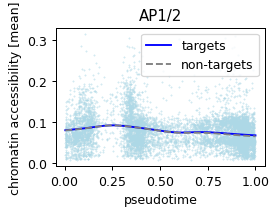

0.08973802337474156

In [202]:
plot_chromatin('AP1/2', sigma_chrom, group_key='celltype',
               # key_sel='Beta',
               q_thr=.84, show=True, save=None)

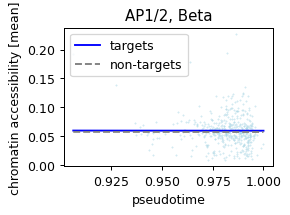

0.22364762461104337

In [203]:
plot_chromatin('AP1/2', sigma_chrom, group_key='celltype', key_sel='Beta', q_thr=.84, show=True, save=None)

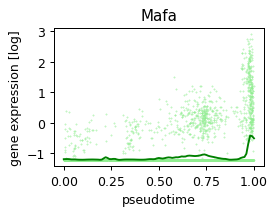

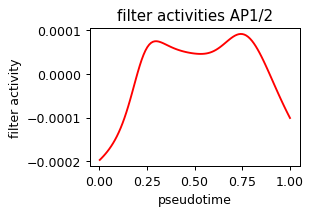

In [204]:
plot_pseudotime('Mafa', 'AP1/2', sigma_gex=.01, sigma_filter=.1,
                save="../../../output/pancreas_mafa_bzip")


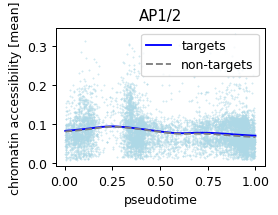

0.18744242662916832

In [205]:
plot_chromatin('AP1/2', sigma_chrom, group_key='celltype', q_thr=.95, show=True, save='../../../output/pancreas_ap1_1')

In [215]:
sigma_chrom

0.1

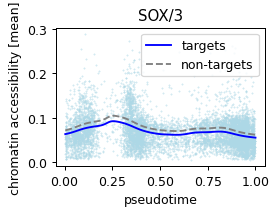

-0.9421069034107382

In [225]:
rcParams['figure.figsize'] = 3, 2
plot_chromatin('SOX/3', .04, q_thr=.95, show=True, save='../../../output/pancreas_sox3')

39
here
0.9 (5000,)
0.9 (45000,)


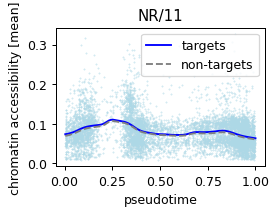

51
here
0.9 (5000,)
0.9 (45000,)


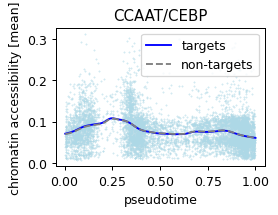

0.0034247913106122754

In [186]:
# plt.close()
plot_chromatin('NR/11', sigma_chrom, q_thr=.9, show=True, save='../../../output/pancreas_nr11')
plot_chromatin('CCAAT/CEBP', sigma_chrom, q_thr=.9, show=True, save='../../../output/pancreas_ccaat')

In [187]:
anno[anno['Name'] == 'CCAAT/CEBP']

Cluster_ID        Name   DBD             Seed_motif  Total_width  Consensus_left  Consensus_right  Cluster_size Name_unique
9          52  CCAAT/CEBP  bZIP  CEBPA_HUMAN.H11MO.0.A           14               2               11            37  CCAAT/CEBP

247
here
0.9 (5000,)
0.9 (45000,)


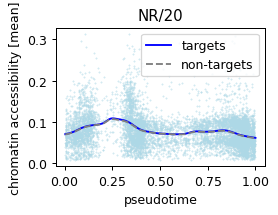

0.08752305422098165

In [188]:
plot_chromatin('NR/20', sigma_chrom, q_thr=.9, show=True, save='../../../output/pancreas_ccaat')

In [191]:
module_names = set(res['module_name'])

diff_pseudotime_by_module = []
for name in module_names:
    sigma_chrom = .03
    diff = plot_chromatin(name, sigma_chrom, q_thr=.99, show=False)
    diff_pseudotime_by_module.append([name, diff])
    print(name, diff)
# filter_name = 'SOX/4'
# sigma_chrom = .03
# plot_chromatin(filter_name, sigma_chrom, q_thr=.9)

# filter_name = 'SOX/3'
# sigma_chrom = .03
# plot_chromatin(filter_name, sigma_chrom, q_thr=.84)

# filter_name = 'NR/11'
# sigma_chrom = .02
# plot_chromatin(filter_name, sigma_chrom, q_thr=.95)

# filter_name = 'PAX/1'
# sigma_chrom = .03
# plot_chromatin(filter_name, sigma_chrom, q_thr=.99)
chrom = pd.DataFrame(diff_pseudotime_by_module, columns=['module', 'diff'])

Ebox/CAGATGG -0.4463687105064015
ETS/2 1.3841551210348784
NFKB/3 -0.029245373729375405
HIC/1 -0.00970106750741416
SOX/4 -0.3864617779577727
ZIC/2 -0.001678147728974927
NRF1 -1.2149584090135126
Ebox/CACGTG/2 0.7070329100372075
GC-tract -0.352908705694854
AIRE -0.039780363278249894
NR/16 0.3818001510819134
CCAAT/CEBP -1.0215220720248988
ZNF28 -1.054292635566007
HD/25 -0.3858228067283669
HD/18 0.3678626404024407
BATF 0.8496393614191722
YY1 -0.6374268295097316
SOX/3 -0.9099718303214782
Ebox/CACGTG/1 -0.7772530907996553
EBF1 -0.011737208270374451
HLTF -1.4430974820992746
STAT/2 0.623677270427765
NR/5 -0.42165050996851433
SNAI2 -0.029305342214546663
SMAD 2.878415515952871
E2F/3 0.6617957710935988
CPEB1 0.7573968834971179
MYB/1 0.5095461009114091
SREBF1 -0.011737208270374451
SOX/6 0.9916724448590001
POU/3 -0.8682258245449043
CENBP 2.0772878400552517
NFAT/1 -0.34609716253812495
CREB/ATF/1 0.9182118987611131
CREB/ATF/3 -0.5941427179558985
CUX/2 -0.6188109979961864
BCL6/1 1.2951623121745122
TBX/